In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import scipy.stats as sps
from scipy.special import boxcox, inv_boxcox,inv_boxcox1p
import pickle

In [4]:
import xgboost as xgb
from xgboost import plot_tree

In [19]:
# Retrieve stored variables from preprocessing notebook

%store -r Xlog_train_ss
%store -r Xlog_val_ss
%store -r Xlog_test_ss 

%store -r Xlog_train
%store -r Xlog_val
%store -r Xlog_test

%store -r ylog_train
%store -r ylog_val
%store -r ylog_test 

%store -r X_train
%store -r X_val
%store -r X_test

%store -r y_train
%store -r y_val
%store -r y_test

%store -r X_train_ss
%store -r X_val_ss
%store -r X_test_ss

%store -r X
%store -r y

## XGBoost Hyper Parameter Optimization

### Compare 4 different combinations
I want to find out if the models work better with normalization and standardscaling and so I setup 4 different combinations: 

- Normalized X+y, No StandardScaling
- Normalized y, No StandardScaling
- Normalized y, StandardScaling for X
- No Normalization, No StandardScaling

### 1. Using cross_val_score R2 for comparison

In [4]:
# Use Cross Validation on 4 different regressors to compare their R2 scores

xg_reg_1=xgb.XGBRegressor()
results_1 = cross_val_score(xg_reg_1, Xlog_train, ylog_train, cv=KFold(n_splits=5))

xg_reg_2=xgb.XGBRegressor()
results_2 = cross_val_score(xg_reg_2, X_train, ylog_train, cv=KFold(n_splits=5))

xg_reg_3=xgb.XGBRegressor()
results_3 = cross_val_score(xg_reg_3, X_train_ss, ylog_train, cv=KFold(n_splits=5))

xg_reg_4=xgb.XGBRegressor()
results_4 = cross_val_score(xg_reg_4, X_train, y_train, cv=KFold(n_splits=5))

print("Normalized X+y, No StandardScaling - CV average R2 score  : %.7f" % results_1.mean())
print("Normalized y, No StandardScaling - CV average R2 score    : %.7f" % results_2.mean())
print("Normalized y, StandardScaling for X - CV average R2 score : %.7f" % results_3.mean())
print("No Normalization, No StandardScaling - CV average R2 score: %.7f" % results_4.mean())

Normalized X+y, No StandardScaling - CV average R2 score  : 0.8930412
Normalized y, No StandardScaling - CV average R2 score    : 0.8930412
Normalized y, StandardScaling for X - CV average R2 score : 0.8930412
No Normalization, No StandardScaling - CV average R2 score: 0.9658989


In [166]:
X[['model_type_s1','model_type_s2']]

,model_type_s1,model_type_s2
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
80892,0,0
80893,0,0
80894,0,0
80895,0,0


### 2. Using RMSE for comparison

#### 2a Normalized X+y, No StandardScaling

In [9]:
## Hyper Parameter Optimization for the first model
xg_reg_1=xgb.XGBRegressor()
n_estimators = [100, 500]
max_depth = [2, 6]
booster=['gbtree','dart']
learning_rate=[0.1, 0.3]
base_score=[0.5,0.75]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'booster':booster,
    'learning_rate':learning_rate,
    'base_score':base_score
    }

# Set up the random search with cross validation
random_cv_1 = RandomizedSearchCV(estimator=xg_reg_1,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=30,
            scoring = 'neg_mean_squared_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv_1.fit(Xlog_train,ylog_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 13.0min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 29.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [23]:
log_train_pred_1 = random_cv_1.predict(Xlog_train)
log_val_pred_1 = random_cv_1.predict(Xlog_val)

train_pred_1 = inv_boxcox(log_train_pred_1,-0.6)
val_pred_1 = inv_boxcox(log_val_pred_1,-0.6)

rmse_train_1 = mean_squared_error(y_train, train_pred_1, squared=False)
rmse_val_1 = mean_squared_error(y_val, val_pred_1, squared=False)

print("Normalized X+y, No StandardScaling")
print("----------------------------------")
print("Training RMSE: %f" % (rmse_train_1))
print("Validation RMSE: %f" % (rmse_val_1))

Normalized X+y, No StandardScaling
----------------------------------
Training RMSE: 47096.255119
Validation RMSE: 47048.371842


In [20]:
# Save model 1
with open('saved_models/xgb1.pkl', 'wb') as file:
    pickle.dump(random_cv_1, file)

#### 2b Normalized y, No StandardScaling

In [22]:
## Hyper Parameter Optimization
xg_reg_2=xgb.XGBRegressor()
n_estimators = [100, 500]
max_depth = [2, 6]
booster=['gbtree','dart']
learning_rate=[0.1, 0.3]
base_score=[0.5,0.75]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'booster':booster,
    'learning_rate':learning_rate,
    'base_score':base_score
    }

# Set up the random search with cross validation
random_cv_2 = RandomizedSearchCV(estimator=xg_reg_2,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=30,
            scoring = 'neg_mean_squared_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv_2.fit(X_train,ylog_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 13.6min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 29.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [24]:
log_train_pred_2 = random_cv_2.predict(X_train)
log_val_pred_2 = random_cv_2.predict(X_val)

train_pred_2 = inv_boxcox(log_train_pred_2,-0.6)
val_pred_2 = inv_boxcox(log_val_pred_2,-0.6)


rmse_train_2 = mean_squared_error(y_train, train_pred_2, squared=False)
rmse_val_2 = mean_squared_error(y_val, val_pred_2, squared=False)

print("Normalized y, No StandardScaling")
print("----------------------------------")
print("Training RMSE: %f" % (rmse_train_2))
print("Validation RMSE: %f" % (rmse_val_2))

Normalized y, No StandardScaling
----------------------------------
Training RMSE: 47096.255119
Validation RMSE: 47048.371842


In [ ]:
# Save model 2
with open('saved_models/xgb2.pkl', 'wb') as file:
    pickle.dump(random_cv_2, file)

#### 2c Normalized y, StandardScaling for X

In [ ]:
## Hyper Parameter Optimization
xg_reg_3=xgb.XGBRegressor()
n_estimators = [100, 500]
max_depth = [2, 6]
booster=['gbtree','dart']
learning_rate=[0.1, 0.3]
base_score=[0.5,0.75]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'booster':booster,
    'learning_rate':learning_rate,
    'base_score':base_score
    }

# Set up the random search with cross validation
random_cv_3 = RandomizedSearchCV(estimator=xg_reg_3,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=30,
            scoring = 'neg_mean_squared_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv_3.fit(X_train_ss,ylog_train)

In [ ]:
log_train_pred_3 = random_cv_3.predict(X_train_ss)
log_val_pred_3 = random_cv_3.predict(X_val_ss)

train_pred_3 = inv_boxcox(log_train_pred_3,-0.6)
val_pred_3 = inv_boxcox(log_val_pred_3,-0.6)

rmse_train_3 = mean_squared_error(y_train, train_pred_3, squared=False)
rmse_val_3 = mean_squared_error(y_val, val_pred_3, squared=False)

print("Training RMSE: %f" % (rmse_train_3))
print("Validation RMSE: %f" % (rmse_val_3))

In [ ]:
# Save model 3
with open('saved_models/xgb3.pkl', 'wb') as file:
    pickle.dump(random_cv_3, file)

#### 2d No Normalization, No StandardScaling

In [150]:
## Hyper Parameter Optimization
xg_reg_4=xgb.XGBRegressor()
n_estimators = [100, 500]
max_depth = [2, 6]
booster=['gbtree','dart']
learning_rate=[0.1, 0.3]
base_score=[0.5,0.75]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'booster':booster,
    'learning_rate':learning_rate,
    'base_score':base_score
    }

# Set up the random search with cross validation
random_cv_4 = RandomizedSearchCV(estimator=xg_reg_4,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=30,
            scoring = 'neg_mean_squared_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv_4.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 19.3min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 41.2min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 125.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [151]:
# Save model 4
with open('saved_models/xgb4.pkl', 'wb') as file:
    pickle.dump(random_cv_4, file)

In [153]:
train_pred_4 = random_cv_4.predict(X_train)
val_pred_4 = random_cv_4.predict(X_val)

rmse_train_4 = mean_squared_error(y_train, train_pred_4, squared=False)
rmse_val_4 = mean_squared_error(y_val, val_pred_4, squared=False)

print("No Normalization, No StandardScaling")
print("------------------------------------")
print("Training RMSE: %f" % (rmse_train_4))
print("Validation RMSE: %f" % (rmse_val_4))

No Normalization, No StandardScaling
------------------------------------
Training RMSE: 19957.662522
Validation RMSE: 24319.594238


### Summary of Model Comparison
|Model|Normalize X|Normalize y|Standardscaling|CV R2 Score|Training RMSE|Validation RMSE|
|---|---|---|---|---|---|---|
| 1 |Yes|Yes|No|0.87|47096.255119|47048.371842|
| 2 |Yes|No |No|0.87|47096.255119|47048.371842|
| 3 |Yes|No |Yes|0.87|47096.255119|47048.371842|
| 4 |No |No |No |0.96|1997.66|24319.59|

The RMSE score from Keras from notebook 7_keras : <br/>
- RMSE Training :  45412.3960336
- RMSE Validation : 45589.5989104
- R2 Score: 0.9007644

The baseline score from Ordinary Least Square (in preprocessing notebook) was: <br/>
- RMSE training: 46408.234820<br/>
- RMSE validation: 46987.788686<br />
- CV R2 score: 0.8851190<br />

The objective is to improve the baseline RMSE by at least 10%, so the first 3 XGBoost models and Keras don't meet the requirement. I choose XGBoost Model 4 for scoring better in R2 and RMSE.

https://stats.stackexchange.com/questions/204489/discussion-about-overfit-in-xgboost

In [152]:
random_cv_4.best_params_

{'n_estimators': 500,
 'max_depth': 6,
 'learning_rate': 0.1,
 'booster': 'dart',
 'base_score': 0.75}

In [36]:
# create a regressor. Using the RandomizedSearchCV's best params as reference, 
# the objective is to reduce overfitting

xg_reg_4a=xgb.XGBRegressor(base_score=0.75, booster='dart', max_depth=6,
                            learning_rate=0.03, n_estimators=500, subsample=0.2,
                           objective='reg:squarederror')


eval_set = [(X_train, y_train), (X_val, y_val)]
xg_reg_4a.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds=5, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:447099.15625	validation_1-rmse:447341.31250
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:434014.06250	validation_1-rmse:434258.56250
[2]	validation_0-rmse:421310.59375	validation_1-rmse:421555.62500
[3]	validation_0-rmse:408999.78125	validation_1-rmse:409260.34375
[4]	validation_0-rmse:397086.21875	validation_1-rmse:397358.50000
[5]	validation_0-rmse:385497.31250	validation_1-rmse:385764.09375
[6]	validation_0-rmse:374269.34375	validation_1-rmse:374548.25000
[7]	validation_0-rmse:363400.93750	validation_1-rmse:363682.34375
[8]	validation_0-rmse:352797.71875	validation_1-rmse:353094.59375
[9]	validation_0-rmse:342568.96875	validation_1-rmse:342887.90625
[10]	validation_0-rmse:332646.93750	validation_1-rmse:332971.84375
[11]	validation_0-rmse:323019.81250	validation_1-rmse:323354.62500
[12]	validation_0-rmse:313671.34375	validation_1

[122]	validation_0-rmse:39272.67188	validation_1-rmse:40678.41406
[123]	validation_0-rmse:39116.67969	validation_1-rmse:40524.89453
[124]	validation_0-rmse:38933.08594	validation_1-rmse:40335.20312
[125]	validation_0-rmse:38769.60938	validation_1-rmse:40169.77734
[126]	validation_0-rmse:38622.17188	validation_1-rmse:40026.60547
[127]	validation_0-rmse:38454.63281	validation_1-rmse:39860.24609
[128]	validation_0-rmse:38276.64062	validation_1-rmse:39690.71875
[129]	validation_0-rmse:38164.36719	validation_1-rmse:39579.42969
[130]	validation_0-rmse:38039.73438	validation_1-rmse:39463.90234
[131]	validation_0-rmse:37869.91406	validation_1-rmse:39309.23047
[132]	validation_0-rmse:37763.38281	validation_1-rmse:39206.66016
[133]	validation_0-rmse:37661.55469	validation_1-rmse:39106.54688
[134]	validation_0-rmse:37519.68359	validation_1-rmse:38964.39844
[135]	validation_0-rmse:37426.44531	validation_1-rmse:38874.73828
[136]	validation_0-rmse:37297.04688	validation_1-rmse:38756.15625
[137]	vali

[247]	validation_0-rmse:32052.78125	validation_1-rmse:33862.45312
[248]	validation_0-rmse:32032.48828	validation_1-rmse:33846.82812
[249]	validation_0-rmse:32006.55859	validation_1-rmse:33822.29688
[250]	validation_0-rmse:31951.15234	validation_1-rmse:33774.15625
[251]	validation_0-rmse:31945.08398	validation_1-rmse:33769.33984
[252]	validation_0-rmse:31916.98438	validation_1-rmse:33744.81641
[253]	validation_0-rmse:31906.33984	validation_1-rmse:33734.59375
[254]	validation_0-rmse:31890.25195	validation_1-rmse:33721.39844
[255]	validation_0-rmse:31873.35156	validation_1-rmse:33713.07812
[256]	validation_0-rmse:31843.30664	validation_1-rmse:33685.17969
[257]	validation_0-rmse:31835.48633	validation_1-rmse:33676.20312
[258]	validation_0-rmse:31810.66797	validation_1-rmse:33656.41406
[259]	validation_0-rmse:31793.87891	validation_1-rmse:33640.00391
[260]	validation_0-rmse:31764.84180	validation_1-rmse:33614.07031
[261]	validation_0-rmse:31730.07617	validation_1-rmse:33581.67969
[262]	vali

[372]	validation_0-rmse:29321.38477	validation_1-rmse:31423.43750
[373]	validation_0-rmse:29310.17969	validation_1-rmse:31417.69336
[374]	validation_0-rmse:29280.91602	validation_1-rmse:31391.89648
[375]	validation_0-rmse:29277.02734	validation_1-rmse:31390.34766
[376]	validation_0-rmse:29266.50781	validation_1-rmse:31379.67773
[377]	validation_0-rmse:29263.19141	validation_1-rmse:31379.34766
[378]	validation_0-rmse:29257.08594	validation_1-rmse:31373.49023
[379]	validation_0-rmse:29238.41797	validation_1-rmse:31351.82031
[380]	validation_0-rmse:29226.43359	validation_1-rmse:31341.18750
[381]	validation_0-rmse:29217.41797	validation_1-rmse:31334.22656
[382]	validation_0-rmse:29198.11914	validation_1-rmse:31319.47070
[383]	validation_0-rmse:29177.47266	validation_1-rmse:31299.03125
[384]	validation_0-rmse:29153.13086	validation_1-rmse:31278.13477
[385]	validation_0-rmse:29147.45312	validation_1-rmse:31276.64844
[386]	validation_0-rmse:29142.93359	validation_1-rmse:31272.19336
[387]	vali

[497]	validation_0-rmse:27471.37109	validation_1-rmse:29803.41211
[498]	validation_0-rmse:27466.24219	validation_1-rmse:29799.10352
[499]	validation_0-rmse:27456.80859	validation_1-rmse:29790.44727


XGBRegressor(base_score=0.75, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.2,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
pred_4a = xg_reg_4a.predict(X_train)
val_pred_4a = xg_reg_4a.predict(X_val)

rmse_4a = mean_squared_error(y_train, pred_4a, squared=False)
rmse_val_4a = mean_squared_error(y_val, val_pred_4a, squared=False)

print("Training RMSE: %f" % (rmse_4a))
print("Val RMSE: %f" % (rmse_val_4a))

Training RMSE: 27456.821996
Val RMSE: 29790.452648


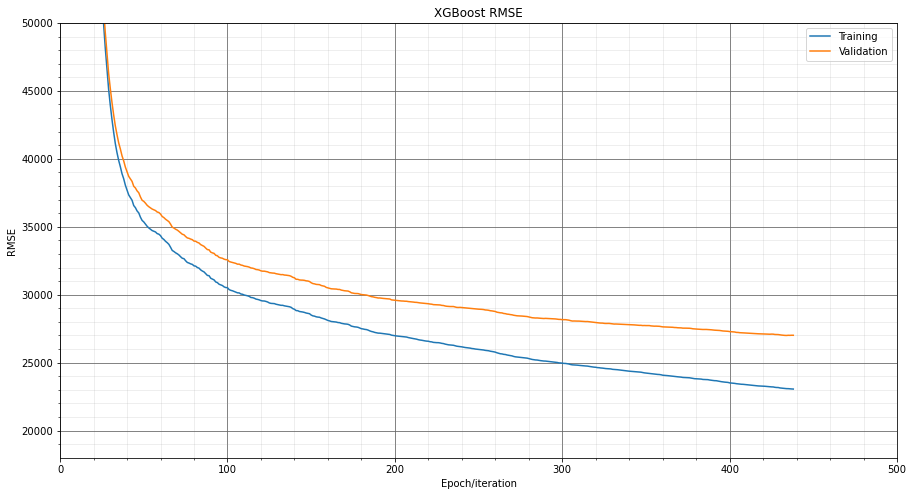

In [25]:
### retrieve performance metrics
history_4 = xg_reg_4a.evals_result()
epochs = len(history_4['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot RMSE
fig, ax = plt.subplots(figsize=(15,8))
plt.ylim(18000,50000)
plt.xlim(0,500)
ax.plot(x_axis, history_4['validation_0']['rmse'], label='Training')
ax.plot(x_axis, history_4['validation_1']['rmse'], label='Validation')
ax.legend()
plt.ylabel('RMSE')
plt.xlabel('Epoch/iteration')
plt.title('XGBoost RMSE')

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
         
plt.show()

This plot shows how the train and test RMSE change over hundreds of iteractions. Their gap will get bigger if I allow more than iteration, which I do not wish to avoid too much of overfitting.

### Important Features that influenced the results

In [9]:
X_train.columns

Index(['floor_area_sqm', 'remaining_lease', 'floor_range', 'model_dbss',
       'model_maisonette', 'model_terrace', 'model_type_s1', 'model_type_s2',
       'type_2_room', 'type_3_room', 'type_4_room', 'type_5_room',
       'type_executive', 'type_multi_generation', 'cli', 'pmi', 'cpi',
       'gdp_growth', 'unemployed_rate', 'dist_mrt', 'dist_mall', 'dist_market',
       'dist_park', 'dist_attraction', 'dist_sport', 'dist_core'],
      dtype='object')

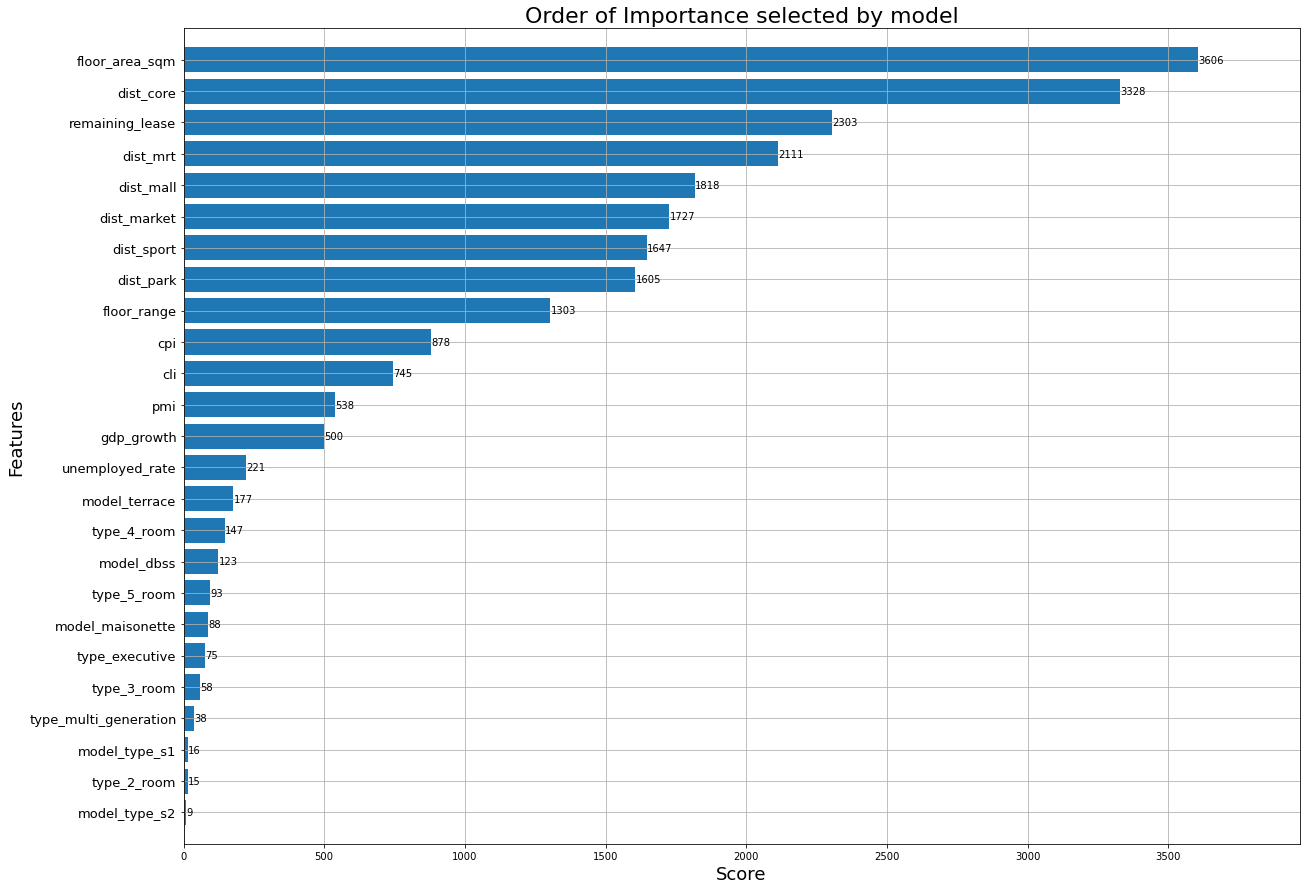

In [38]:
features =['floor_area_sqm', 'remaining_lease', 'floor_range', 'model_dbss',
       'model_maisonette', 'model_terrace', 'model_type_s1', 'model_type_s2',
       'type_2_room', 'type_3_room', 'type_4_room', 'type_5_room',
       'type_executive', 'type_multi_generation', 'cli', 'pmi', 'cpi',
       'gdp_growth', 'unemployed_rate', 'dist_mrt', 'dist_mall', 'dist_market',
       'dist_park', 'dist_sport', 'dist_core']

plt.rcParams['figure.figsize'] = (20, 15)

xg_reg_4a.get_booster().feature_names = features
xgb.plot_importance(xg_reg_4a.get_booster(),height=0.8)

plt.title('Order of Importance selected by model', fontsize=22)
plt.xlabel('Score', fontsize = 18)
plt.ylabel('Features', fontsize = 18)
plt.yticks(fontsize=13)
plt.show()


This plot shows which are the features that influenced the predictions, with the most important features at the top. It is not surprising that Floor Area is the most important feature, but it is also important to note that this is not the only feature that affects the price of a property.

Next is the Remaining Lease, which is important for HDB flats because all of them are 99 years leasehold properties, which means that at the end of 99 years the property will be returned to the state at zero value. That is why older flats fetch lower prices, assuming all other factors being equal.

The location of a flat means its proximities to points of interest, including the Downtown Core. Buyers are willing to pay more if the flats are near to Downtown Core, which is the economic and cultural heart of Singapore. In private residential market the government maintain indices for three different regions, and downtown core belongs to the region with the most expensive private properties.

Other Points of Interests also influence the price of a flat, such as nature parks, shopping malls, markets, sport facilities and attractions. But the one that most buyers look for is MRT station. With 60% of the population traveling to work/school in public transport, proximity to MRT station became an important price predictor.

Flats at higher floors are getting lesser noise from the street and offer better views, so it is shown here as an important factor.

Marcoeconomic factors also play a part in determining flat prices, such as CPI (consumer price index), PMI (purchasing manager index), CLI (composite index) and GDP growth rate. Buying a home is a big investment. During a recession people are worried about their jobs and their ability to service the loan, and that would put downward pressure on price.

In [56]:
# Save the model for deployment with flask

import pickle
with open('../webapp/model/xg_reg_4a.pkl', 'wb') as file:
    pickle.dump(xg_reg_4a, file)

I will be using the web interface to verify the predictions for 2020 dataset

In [57]:
xg_reg_4a = pickle.load(open('../webapp/model/xg_reg_4a.pkl', 'rb'))

In [58]:
pred = xg_reg_4a.predict(X_test)

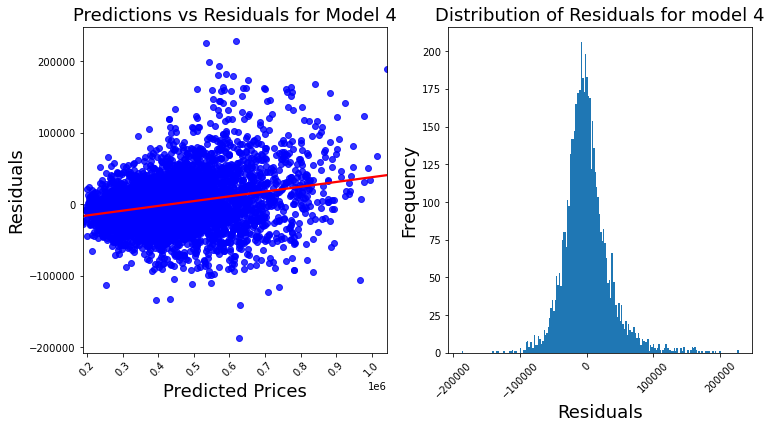

In [61]:
# specify the plot size
fig = plt.figure(figsize=(12, 6))

# Predictions vs Residuals
plt.subplot(1,2,1)
sns.regplot(pred, y_test-pred,ci=None, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel('Predicted Prices',fontsize=18)
plt.ylabel('Residuals',fontsize=18)
plt.xticks(fontsize=10,rotation=45)
plt.title('Predictions vs Residuals for Model 4',fontsize=18)
plt.yticks(fontsize=10);

# Residual Distribution
plt.subplot(1,2,2)
plt.hist(y_test-pred,bins=200);
plt.xlabel('Residuals',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xticks(fontsize=10,rotation=45)
plt.title('Distribution of Residuals for model 4',fontsize=18)
plt.yticks(fontsize=10);

The residuals are found to be normally distributed

In [62]:
import scipy.stats as stats

normal_distr_values = y_test-pred
plus_one_std_dev = np.mean(normal_distr_values) + np.std(normal_distr_values)
minus_one_std_dev = np.mean(normal_distr_values) - np.std(normal_distr_values)

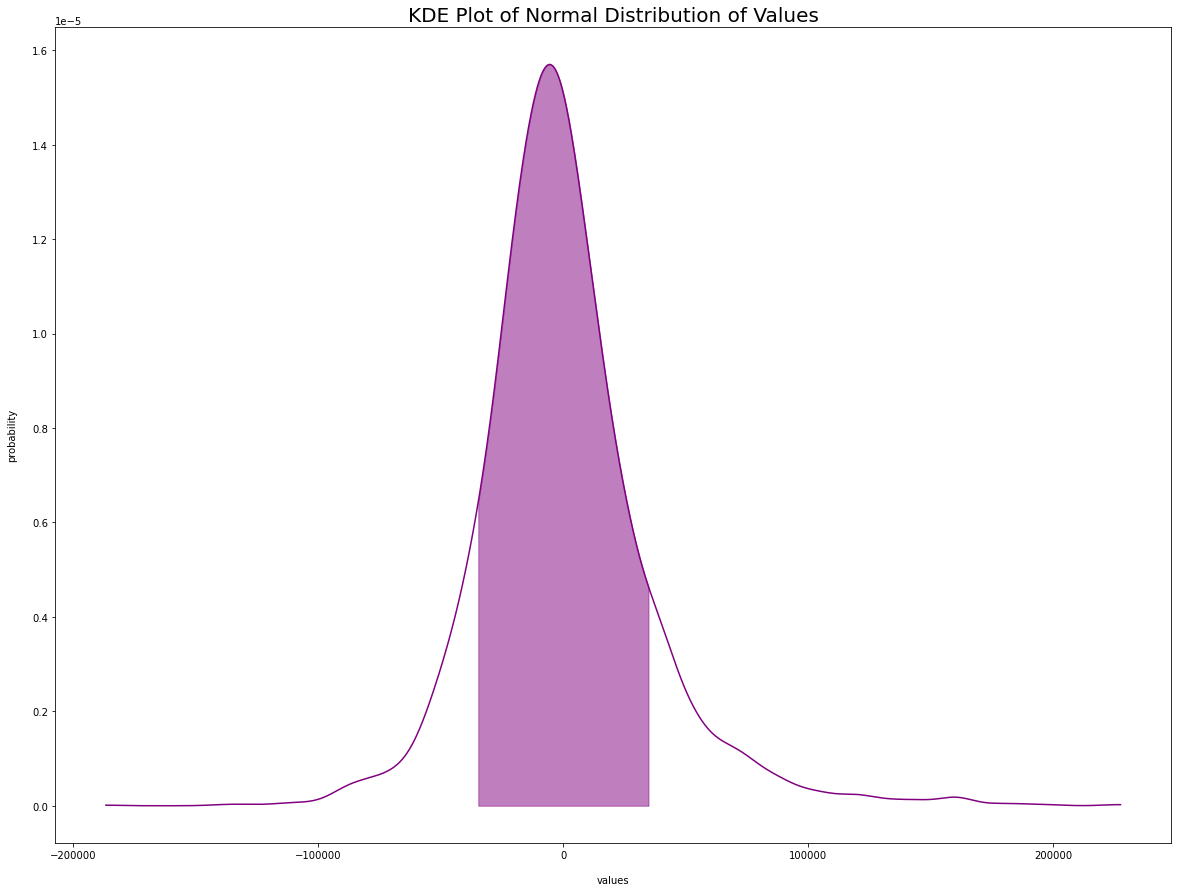

In [73]:
kde = stats.gaussian_kde(normal_distr_values)
pos = np.linspace(min(normal_distr_values), max(normal_distr_values), 50000)
plt.plot(pos, kde(pos), color='purple')
shade = np.linspace(minus_one_std_dev, plus_one_std_dev, 300)
plt.fill_between(shade, kde(shade), alpha=0.5, color='purple',)
# plt.text(horizontalalignment='center', fontsize=16, 
#          s="68% of values fall within\n this shaded area of\n plus or minus 1 standard\n deviation from the mean", 
#          bbox=dict(facecolor='whitesmoke', boxstyle="round, pad=0.25"))
plt.title("KDE Plot of Normal Distribution of Values", fontsize=20)
plt.xlabel("values", labelpad=15)
plt.ylabel("probability", labelpad=15);

In [74]:
for number_deviations in [-3, -2, -1, 1, 2, 3]:
    value = round(np.mean(normal_distr_values) + number_deviations * np.std(normal_distr_values), 1)
    print("{0} is {1} standard deviations from the mean".format(value, number_deviations))

-104176.8 is -3 standard deviations from the mean
-69447.2 is -2 standard deviations from the mean
-34717.7 is -1 standard deviations from the mean
34741.5 is 1 standard deviations from the mean
69471.0 is 2 standard deviations from the mean
104200.6 is 3 standard deviations from the mean


Using the 68-95-99.7 empirical rule,

68% of the residuals are between -34,741 and 34,741
95% of the residuals are between -69,447 and 69,447
99.7% of the residuals are between -104,176.8 and 104,176.8